In [1]:
import os
import re
import h5py
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle as pkl

import nltk
from nltk.corpus import stopwords
languages = ['english', 'german', 'french', 'finnish', 'swedish', 'norwegian', 'danish', 'russian']
stop_words = set()
for language in languages:
    stop_words.update(set(stopwords.words(language)))
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

from mlxtend.classifier import StackingClassifier
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler, SMOTE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

import lightgbm as lgb

Using TensorFlow backend.


# Data

See previous chapters for more discussion about the data set. The data set is formatted as an array comprised of one independent variable (lyrics) and five dependent variable labels (genres), for each row (song). Since each song can belong to any ore none of the genres, the task of tagging song lyrics with the appropriate genre labels is a multi-label classification problem.

In [2]:
df = pd.read_hdf('combined-data/lyrics-genres.h5', key='df', mode='r')
X = df.pop('lyrics').values
y = df.values
genres = df.columns

# Multi-label classification tools

**Binary relevance** is the simplest method of classifying multiple labels at once; it trains an independant classifier for each label, breaking the multi-label problem down into many binary classification problems ([Zhang, M., Li, Y., Liu, X., et al, 2018](http://palm.seu.edu.cn/zhangml/files/FCS'17.pdf)). In this context a binary classifier would be trained on each genre, and a song's genre tags predicted by concatenating the predictions of all genre classifiers. The advantage of this method is that the number of classifiers needed is equal to the number of labels, so the computational cost scales linearly with how many labels we want to predict. However, by assuming that the labels are independent, this method fails to capture correlations between labels. For example, the "heavy" and "power" genre labels are more likely to appear together, so an song's likelihood of being tagged as power metal should be higher if it is also tagged as heavy metal as opposed to, say, black metal. Another issue is that each binary classifier will face a class imbalance problem due to the sparsity of genre tags.

In the **classifier chain** method, a classifier is trained on one label and its output is fed as an additional feature to the next label, and so on until all labels have been exhausted ([Read, J., Pfahringer, B., Holmes., G, Frank, E. 2011](https://www.cs.waikato.ac.nz/~eibe/pubs/chains.pdf)). This again requires only as many classifiers as there are labels, but unlike binary relevance it does learn correlations between labels. However, the correlations it is capable of learning can vary with different chain orders.

Unlike the above two methods, which transform the multi-label problem into multiple independant binary classification problems, the **label powerset** method transforms it into a single multi-class problem by treating every combination of labels as its own class. For example, from the genres in the metal lyrics dataset, "black" + "death", "black" + "power", "black" + "death" + "power" would each yield a new class. This tackles the issue of correlated labels head-on by treating correlations as classes on their own, but comes at the cost of having smaller class sizes to train on and consequently an even bigger class imbalance problem. This issue inspired the **RAndom k-labELsets (RAKEL)** method, which uses an ensemble of classifiers, each trained on a random subset of labels ([Rokach, L., Schclar, A., Itach, E. 2013](https://arxiv.org/ftp/arxiv/papers/1307/1307.1769.pdf)).

In [9]:
class BinaryRelevance:
    def __init__(self, classifier, labels):
        self.classifier = classifier
        self.labels = labels
        self.classifiers_ = []

    def fit(self, X, y):
        for i, label in enumerate(self.labels):
            print('training binary classifier for label: {}'.format(label))
            clf = deepcopy(self.classifier)
            clf.fit(X, y[:, i])
            self.classifiers_.append((label, clf))

    def predict(self, X):
        return self._predict(X)

    def predict_proba(self, X):
        return self._predict(X, return_prob=True)

    def _predict(self, X, return_prob=False):
        y = np.zeros((X.shape[0], len(self.classifiers_)))
        for i, (label, clf) in enumerate(self.classifiers_):
            if return_prob:
                y[:, i] = clf.predict_proba(X)[:, 1]
            else:
                y[:, i] = clf.predict(X)
        return y

    def cross_validate(self, X, y, n_splits=5, verbose=False):
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
        y_prob, y_valid = np.zeros(y.shape), np.zeros(y.shape)
        for i, label in enumerate(self.labels):
            if verbose:
                print("Training on label '{}'".format(label))
            scores = np.zeros((n_splits, 4))
            confusion_matrices = np.zeros((n_splits, 2, 2))
            for j, (train_idx, valid_idx) in enumerate(kfold.split(X, y[:, i])):
                if verbose:
                    print("Fold {}/{}".format(j + 1, n_splits))
                X_fold_train, y_fold_train = X[train_idx], y[train_idx, i]
                X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx, i]
                clf = deepcopy(self.classifier)
                clf.fit(X_fold_train, y_fold_train)
                try:
                    y_fold_prob = clf.predict_proba(X_fold_valid)[:, 1]
                except AttributeError:
                    y_fold_prob = clf.predict(X_fold_valid).reshape(-1)
                y_prob[valid_idx, i] = y_fold_prob
                y_valid[valid_idx, i] = y_fold_valid
                y_fold_pred = y_fold_prob.round()
                scores[j, 0] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
                scores[j, 1] = precision_score(y_fold_valid, y_fold_pred)
                scores[j, 2] = recall_score(y_fold_valid, y_fold_pred)
                scores[j, 3] = f1_score(y_fold_valid, y_fold_pred)
                confusion_matrices[j] = confusion_matrix(y_fold_valid, y_fold_pred)
            if verbose:
                avg_accuracy, avg_precision, avg_recall, avg_f1 = scores.mean(axis=0)
                std_accuracy, std_precision, std_recall, std_f1 = scores.std(axis=0)
                print("CV scores:")
                print("Accuracy:    {:.2f} +/- {:.2f}".format(avg_accuracy, std_accuracy))
                print("Precision:   {:.2f} +/- {:.2f}".format(avg_precision, std_precision))
                print("Recall:      {:.2f} +/- {:.2f}".format(avg_recall, std_recall))
                print("F1-score:    {:.2f} +/- {:.2f}".format(avg_f1, std_f1))
                print("Average confusion matrix:")
                print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)
        return MultiLabelClassification(y_valid, y_prob, labels=self.labels)

In [38]:
class ClassifierChain:
    def __init__(self, classifier, labels):
        self.classifier = classifier
        self.labels = labels
        self.classifiers_ = []

    def fit(self, X, y, verbose=False):
        y_chain = np.zeros((y.shape[0], y.shape[1] - 1))
        print(X.shape, y.shape, y_chain.shape)
        for i in range(y.shape[1]):
            if verbose:
                print('training binary classifier for label: {}'.format(i))
            X_ = X.copy()
            y_ = y[:, i]
            clf = deepcopy(self.classifier)
            if isinstance(clf, Pipeline):
                for name, step in clf.steps:
                    try:
                        X_ = step.fit_transform(X_)
                    except AttributeError:
                        try:
                            if len(X_.shape) > 1:
                                X_, y_ = step.fit_resample(X_[:, : X_.shape[1]], y_)
                            else:
                                X_, y_ = step.fit_resample(X_, y_)
                        except AttributeError:
                            if i > 0:
                                X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                            step.fit(X_, y_)
                            y_pred = step.predict(X_).reshape(-1)
                            print(X_.shape, y_.shape, y_pred.shape)
            else:
                if i > 0:
                    X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                clf.fit(X_, y_)
                y_pred = clf.predict(X_).reshape(-1)
            y_chain[:, i] = y_pred
            self.classifiers.append(clf)

    def predict(self, X):
        return self._predict(X)

    def predict_proba(self, X):
        return self._predict(X, return_prob=True)

    def _predict(self, X, return_prob=False):
        X_chain = X.copy()
        y = np.zeros((X.shape[0], len(self.classifiers_)))
        for i, clf in enumerate(self.classifiers_):
            X_ = X.copy()
            y_ = y[:, i]
            if isinstance(clf, Pipeline):
                for name, step in clf.steps:
                    try:
                        X_ = step.transform(X_)
                    except AttributeError:
                        try:
                            if len(X_.shape) > 1:
                                X_, y_ = step.resample(X_[:, : X_.shape[1]], y_)
                            else:
                                X_, y_ = step.resample(X_, y_)
                        except AttributeError:
                            if i > 0:
                                X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                            y_pred = step.predict(X_).reshape(-1)
                            y_prob = step.predict_proba(X_)[:, 1].reshape(-1)
            else:
                if i > 0:
                    X_ = np.concatenate((X_, y_chain[:, : i]), axis=1)
                y_pred = clf.predict(X_).reshape(-1)
                y_prob = clf.predict_proba(X_)[:, 1].reshape(-1)
            y_chain[:, i] = y_pred
            if return_prob:
                y[:, i] = y_prob
            else:
                y[:, i] = y_pred
        return y

    def cross_validate(self, X, y, n_splits=5, verbose=False):
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)
        y_prob, y_valid = np.zeros(y.shape), np.zeros(y.shape)
        scores = np.zeros((len(self.labels), n_splits, 4))
        confusion_matrices = np.zeros((len(self.labels), n_splits, 2, 2))
        for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
            if verbose:
                print("Fold {}/{}".format(i + 1, n_splits))
            X_fold_train, y_fold_train = X[train_idx], y[train_idx]
            X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx]
            clf = deepcopy(self)
            clf.fit(X_fold_train, y_fold_train)
            try:
                y_fold_prob = clf.predict_proba(X_fold_valid)
            except AttributeError:
                y_fold_prob = clf.predict(X_fold_valid)
            y_prob[valid_idx, :] = y_fold_prob
            y_valid[valid_idx, :] = y_fold_valid
            y_fold_pred = y_fold_prob.round()
            for j, label in enumerate(self.labels):
                scores[j, i, 0] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
                scores[j, i, 1] = precision_score(y_fold_valid, y_fold_pred)
                scores[j, i, 2] = recall_score(y_fold_valid, y_fold_pred)
                scores[j, i, 3] = f1_score(y_fold_valid, y_fold_pred)
                confusion_matrices[j, i] = confusion_matrix(y_fold_valid, y_fold_pred)
        if verbose:
            for j, label in enumerate(self.labels):
                avg_accuracy, avg_precision, avg_recall, avg_f1 = scores[j].mean(axis=0)
                std_accuracy, std_precision, std_recall, std_f1 = scores[j].std(axis=0)
                print("CV scores for label {}:".format(label))
                print("Accuracy:    {:.2f} +/- {:.2f}".format(avg_accuracy, std_accuracy))
                print("Precision:   {:.2f} +/- {:.2f}".format(avg_precision, std_precision))
                print("Recall:      {:.2f} +/- {:.2f}".format(avg_recall, std_recall))
                print("F1-score:    {:.2f} +/- {:.2f}".format(avg_f1, std_f1))
                print("Average confusion matrix:")
                print(confusion_matrices[j].mean(axis=0) / confusion_matrices[j].sum() * n_splits)
        return MultiLabelClassification(y_valid, y_prob, labels=self.labels)

# Evaluation metrics

Since binary relevance involves training independant binary classifiers, each classifier can be evaluated during training and cross-validation using the familiar binary classication metrics.

However, evaluating the overall results requires metrics designed for the multi-label output, which are more complicated than the usual evaluation metrics ([Zhang, M., Zhou, Z. 2014](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkde13rev.pdf)). If $h(\mathbf{x}_i)$ is the model which predicts the labels $Y_i$ based on the independent variables $\mathbf{x}_i$, then over $p$ observations the accuracy, precision, recall, and F scores are defined as

\begin{align}
\mathrm{accuracy}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ labels\ in\ common}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|Y_i \cup h(\mathbf{x}_i)|}\\
\mathrm{precision}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ predicted\ labels\ that\ are\ correct}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|h(\mathbf{x}_i)|}\\
\mathrm{recall}(h) &= \frac{1}{p}\sum_{i=1}^{p}(\mathrm{fraction\ of\ true\ labels\ that\ were\ predicted\ correctly}) &= \frac{1}{p}\sum_{i=1}^{p}\frac{|Y_i \cap h(\mathbf{x}_i)|}{|Y_i|}\\
\mathrm{F_1\ score}(h) &= \mathrm{harmonic\ mean\ of\ precision\ and\ recall} &= 2 \left[ \frac{\mathrm{precision}(h) \cdot \mathrm{recall}(h)}{\mathrm{precision}(h) + \mathrm{recall}(h)} \right]
\end{align}

Another useful metric is the Hamming loss, which is the mean symmetric difference (non-matching genre tags) between the two sets:

$$\mathrm{Hamming}(h) = \frac{1}{p} \sum_{i=1}^{p} |h(\mathbf{x}_i\Delta Y_i|$$

In [10]:
class MultiLabelClassification:

    def __init__(self, y_true, y_pred=None, y_pred_classes=None, labels=None, class_thresh=0.5):
        self.true = y_true.astype(int)
        if y_pred_classes is None and y_pred is not None:
            self.pred = y_pred
            y_pred_classes = np.zeros_like(self.pred, dtype=int)
            y_pred_classes[self.pred > class_thresh] = 1
        else:
            self.pred = None
        self.pred_classes = y_pred_classes
        self.n_samples, self.n_labels = y_true.shape
        if labels is not None:
            if len(labels) == self.n_labels:
                self.labels = np.array(labels)
            else:
                raise ValueError("length of labels and shape of y_true do not match")
        else:
            self.labels = np.arange(self.true.shape[1])

    @property
    def __intersection(self):
        return self.true * self.pred_classes

    @property
    def __union(self):
        return np.minimum(1, self.true + self.pred_classes)

    @property
    def accuracy_score(self):
        # Number of labels in common / overall labels (true and predicted)
        return np.nanmean(self.__intersection.sum(1) / self.__union.sum(1))

    @property
    def precision_score(self):
        # Proportion of predicted labels that are correct
        return np.nanmean(self.__intersection.sum(1) / self.pred_classes.sum(1))

    @property
    def recall_score(self):
        # Proportion of true labels that were predicted
        return np.nanmean(self.__intersection.sum(1) / self.true.sum(1))

    @property
    def f1_score(self):
        # Harmonic mean of precision_score and recall_score
        p = self.precision_score
        r = self.recall_score
        return 2 * (p * r) / (p + r)

    @property
    def hamming_loss(self):
        # Symmetric difference b/w pred and true labels (true XOR pred)
        delta = np.zeros(self.true.shape[0])
        for i in range(delta.shape[0]):
            delta[i] = np.sum(self.true[i] ^ self.pred_classes[i])
        return delta.mean()

    def confusion_matrix(self, label=None, label_idx=None):
        confusion_matrices = multilabel_confusion_matrix(self.true, self.pred_classes)
        if label is not None:
            return confusion_matrices[np.where(self.labels == label)[0][0]]
        elif label_idx is not None:
            return confusion_matrices[label_idx]
        else:
            return confusion_matrices

    def print_report(self, verbose=0):
        print("Multi-label classification report:")
        print("Accuracy:      {:.2f}".format(self.accuracy_score))
        print("Precision:     {:.2f}".format(self.precision_score))
        print("Recall:        {:.2f}".format(self.recall_score))
        print("F1-score:      {:.2f}".format(self.f1_score))
        print("Hamming loss:  {:.2f}".format(self.hamming_loss))
        if verbose == 1:
            for label, matrix in zip(self.labels, self.confusion_matrix()):
                print("===\nLabel: {}".format(label))
                print(matrix)

    def plot_roc_curve(self):
        fig = plt.figure(figsize=(8, 6))
        auc = np.zeros(len(self.labels))
        for i, label in enumerate(self.labels):
            true = self.true[:, i]
            pred = self.pred[:, i]
            fpr, tpr, thresholds = roc_curve(true, pred)
            auc[i] = roc_auc_score(true, pred)
            plt.step(fpr, tpr, label=label)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.gca().set_aspect('equal')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.title("ROC curve", size=20)
        plt.xlabel("False positive rate", size=16)
        plt.ylabel("True positive rate", size=16)
        plt.legend(fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(alpha=0.5)
        return fig, auc

# Pipeline

Two pre-processing steps must be performed before a model can be trained on this dataset:

1. **Vectorization**: To transform the data from raw song lyrics to an array of values ready for training, the lyrics must be vectorized with a bag-of-words method. The `CountVectorizer` turns song's lyrics into a list of word counts. The dataset is thus converted into a matrix representing the term frequency of each word (column) in each song (row). The `TfidfVectorizer` takes this an extra step by computing the term-frequency inverse-document-frequency (TF-IDF) value for each term in a document (song). This quantity measures the frequency of a term in a document relative to its frequency in all documents, thus being a better measure of how unique the term is to that document. These bag-of-words methods fail to capture any syntactical structure in the lyrics, which may be important for genre labeling. A word embedding approach provides a more context-rich representation of the lyrics, and opens up the possibility of training convolutional neural networks over the full documents. This is explored in the next chapter.

2. **Oversampling**: To remedy the class imbalance in each single-genre binary classification, the data can be either oversampled or undersampled to have an equal number of positive and negative class occurences. Undersampling requires no manipulation of the data; the classifier is simply trained with a subset of the majority class equal in number to the minority class. This comes at the cost of reducing the amount of data to train from. Oversampling is often preferred over undersampling. The simplest method of oversampling is random oversampling, in which randomly selected rows from the minority class are duplicated during training. Synthetic Minority Oversampling Technique (SMOTE) is a more complex method that generates new data based on the distribution of values in the minority class [Chawla, N., Bowyer, K., Hall, L., Kegelmeyer, W. 2011](https://arxiv.org/abs/1106.1813). It does so by randomly selecting two observations at a time in the minority class and sampling a new observation from the line between those two in the feature space. This is somewhat like producing from randomly selected parent observations a child whose traits are somewhere between those of its parents. In the context of song lyrics SMOTE would generate new songs with word frequencies (or TF-IDF values) similar to the genre being classified by the binary classifier.

# Logistic regression

One very simple model for a binary classification task is the [`LogisticRegression`](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) classifier, which assumes a linear relationship between the feature variables (word counts) and the log-odds of the target variables (genre). Logistic regression is a very common tool for tackling classification problems in a variety of applications, sometimes under the names logit regression or maximum-entropy (MaxEnt) classification.

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.74 +/- 0.00
Precision:   0.56 +/- 0.00
Recall:      0.63 +/- 0.01
F1-score:    0.59 +/- 0.00
Average confusion matrix:
[[0.66009833 0.11362963]
 [0.08359824 0.1426738 ]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.70 +/- 0.00
Precision:   0.57 +/- 0.01
Recall:      0.61 +/- 0.00
F1-score:    0.59 +/- 0.00
Average confusion matrix:
[[0.53669516 0.14472723]
 [0.12444962 0.19412798]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.70 +/- 0.00
Precision:   0.45 +/- 0.00
Recall:      0.53 +/- 0.01
F1-score:    0.48 +/- 0.01
Average confusion matrix:
[[0.7319091  0.10565285]
 [0.07706281 0.08537524]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.48 +/- 0.01
Recall:      0.57 +/- 0.01
F1-score:    0.52 +/- 0.01
Average confusion matrix:
[[0.72258969 0.10642289]
 [0.07271902 0.09826841]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.06


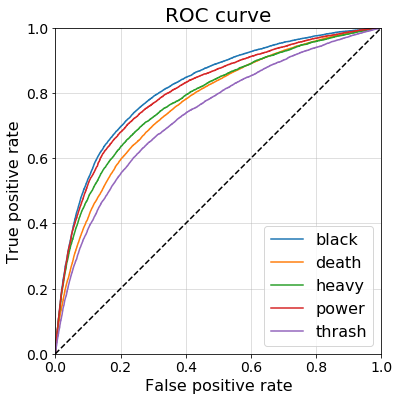

[0.81953027 0.76575025 0.78223942 0.80688227 0.73462532]
AUC ROC score = 0.78 +/- 0.03


In [13]:
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('logreg', LogisticRegression(**lr_params))
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# SGD Classifier

The scikit-learn [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) is a generalized classifier that trains via stochastic gradient descent (SGD). It can assume the form of a logistic regression if using 'log' loss, but by default it uses the 'hinge' loss in which case the linear model it fits is a linear support vector machine (SVM).

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.54 +/- 0.01
Recall:      0.59 +/- 0.01
F1-score:    0.56 +/- 0.01
Average confusion matrix:
[[0.66073015 0.11299781]
 [0.09345075 0.13282129]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.68 +/- 0.00
Precision:   0.56 +/- 0.00
Recall:      0.58 +/- 0.01
F1-score:    0.57 +/- 0.00
Average confusion matrix:
[[0.53470097 0.14672142]
 [0.1353091  0.18326851]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.68 +/- 0.01
Precision:   0.43 +/- 0.01
Recall:      0.48 +/- 0.01
F1-score:    0.45 +/- 0.01
Average confusion matrix:
[[0.73269888 0.10486307]
 [0.08434853 0.07808952]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.69 +/- 0.01
Precision:   0.44 +/- 0.01
Recall:      0.50 +/- 0.01
F1-score:    0.47 +/- 0.01
Average confusion matrix:
[[0.71947006 0.10954252]
 [0.08496061 0.08602681]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.10


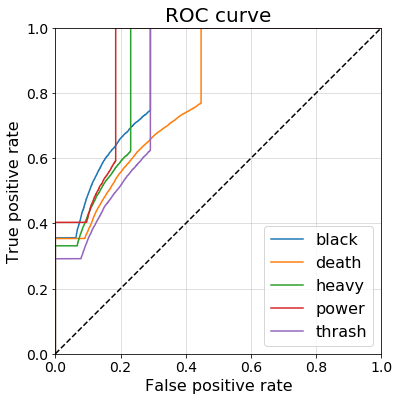

[0.7688474  0.72335291 0.7178901  0.71355291 0.69044885]
AUC ROC score = 0.72 +/- 0.03


In [14]:
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('sgd', SGDClassifier(loss='modified_huber', alpha=0.0001))
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# Naive Bayes

[Naive Bayes classifiers](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) have long been popular in text classification. The method is rooted in Bayes' Theorem, which states the probability of a particular class $y$ given input $\mathbf{x}=(x_1, \dots, x_n)$ can be written as

$$ P(y|\mathbf{x}) = \frac{P(y)P(\mathbf{x}|y)}{P(\mathbf{x})} $$

where $P(y)$, $P(\mathbf{x}|y)$, and $P(\mathbf{x})$ are known as the prior, likelihood and evidence. The evidence is class-independent and can be ignored when comparing the probabilities of different classes, while the likelihood can be expanded using the chain rule for probabilities as

\begin{align}
P(\mathbf{x}|y) &= P(x_1, \dots, x_n|y)\\
                &= P(x_1|x_2, \dots, x_n, y) P(x_2, \dots, x_n|y)\\
                &= \dots\\
                &= P(x_1|x_2, \dots, x_n, y) P(x_2| x_3 \dots, x_n, y) \dots P(x_{n-1}|x_n, y) P(x_n|y) P(y)
\end{align}

The "naive" assumption is that the input variables $x_i$ are assumed to be mutually independent, so $P(x_i|x_{i+1}, \dots, x_n, y) = P(x_i|y)$. Thus the likelihood becomes a product sum of single-feature probabilities $P(x_i|y)$:

$$ P(\mathbf{x}|y) = P(y) \prod_{i=1}^{n} P(x_i|y) $$

Thus the Naive Bayes classification problem can be expressed as a maximum a posteriori estimation (like maximum-likelihood but with a prior term included that behaves like a regularization parameter (see [this blog post](https://wiseodd.github.io/techblog/2017/01/01/mle-vs-map/) for a quick discussion of MAP and MLE)) with the following classification rule:

$$ \hat{y} = \mathrm{argmax}_k P(y_k) \prod_{i=1}^{n} P(x_i|y_k) $$

The scikit-learn implementation [`NaiveBayes`](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) provides different options for the likelihood distribution $P(x_i|y)$. The Multinomial and Bernoulli algorithms are the most popular for document classification tasks.

### Mulitnomial Naive Bayes

In [ ]:
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('multinomialnb', MultinomialNB())
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.74 +/- 0.00
Precision:   0.60 +/- 0.01
Recall:      0.61 +/- 0.01
F1-score:    0.60 +/- 0.00
Average confusion matrix:
[[0.68219243 0.09153553]
 [0.08873181 0.13754023]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.53 +/- 0.01
Recall:      0.76 +/- 0.00
F1-score:    0.62 +/- 0.00
Average confusion matrix:
[[0.46354177 0.21788062]
 [0.07530555 0.24327206]]
Training on label 'heavy'
Fold 1/3


### Complement multinomial Naive Bayes

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.74 +/- 0.00
Precision:   0.60 +/- 0.01
Recall:      0.61 +/- 0.01
F1-score:    0.60 +/- 0.00
Average confusion matrix:
[[0.68219243 0.09153553]
 [0.08873181 0.13754023]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.53 +/- 0.01
Recall:      0.76 +/- 0.00
F1-score:    0.62 +/- 0.00
Average confusion matrix:
[[0.46354177 0.21788062]
 [0.07530555 0.24327206]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.74 +/- 0.01
Precision:   0.36 +/- 0.00
Recall:      0.73 +/- 0.01
F1-score:    0.48 +/- 0.01
Average confusion matrix:
[[0.62566391 0.21189804]
 [0.04326021 0.11917784]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.76 +/- 0.00
Precision:   0.34 +/- 0.00
Recall:      0.85 +/- 0.01
F1-score:    0.49 +/- 0.00
Average confusion matrix:
[[0.54941063 0.27960195]
 [0.0253322  0.14565522]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.39


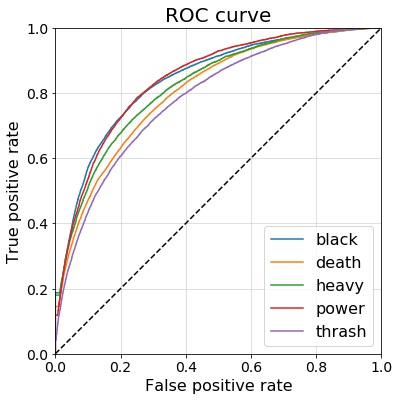

[0.83792566 0.80321494 0.81910219 0.8414475  0.78339295]
AUC ROC score = 0.82 +/- 0.02


In [16]:
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('complementnb', ComplementNB())
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

### Bernoulli Naive Bayes

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.73 +/- 0.00
Precision:   0.62 +/- 0.01
Recall:      0.56 +/- 0.01
F1-score:    0.59 +/- 0.01
Average confusion matrix:
[[0.69644796 0.07728   ]
 [0.09963078 0.12664126]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.53 +/- 0.00
Recall:      0.74 +/- 0.01
F1-score:    0.62 +/- 0.00
Average confusion matrix:
[[0.47528975 0.20613264]
 [0.08199893 0.23657867]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.73 +/- 0.00
Precision:   0.32 +/- 0.00
Recall:      0.78 +/- 0.01
F1-score:    0.46 +/- 0.00
Average confusion matrix:
[[0.56974747 0.26781448]
 [0.03518471 0.12725334]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.76 +/- 0.00
Precision:   0.34 +/- 0.00
Recall:      0.87 +/- 0.00
F1-score:    0.49 +/- 0.00
Average confusion matrix:
[[0.53418761 0.29482496]
 [0.02158075 0.14940668]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.46


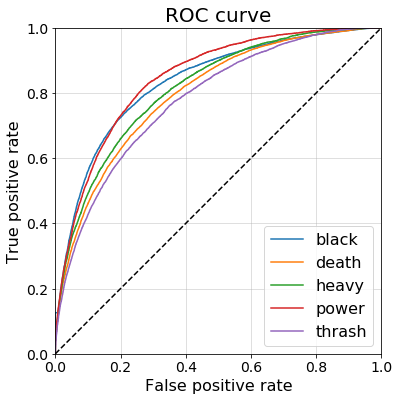

[0.83413697 0.79832941 0.81406839 0.84640479 0.78062993]
AUC ROC score = 0.81 +/- 0.02


In [17]:
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('bernoullinb', BernoulliNB())
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# Random forest classifier

The random forest classifier is a popular choice in classification problems, especially when overfitting is a concern. As an ensemble model, the random forest does a good job of minimizing bias by averaging out the contributions of many hundreds or thousands of predictors.

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.72 +/- 0.00
Precision:   0.51 +/- 0.01
Recall:      0.62 +/- 0.01
F1-score:    0.56 +/- 0.01
Average confusion matrix:
[[0.64238751 0.13134045]
 [0.08691532 0.13935672]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.71 +/- 0.00
Precision:   0.61 +/- 0.01
Recall:      0.59 +/- 0.01
F1-score:    0.60 +/- 0.01
Average confusion matrix:
[[0.56151401 0.11990839]
 [0.13143918 0.18713843]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.70 +/- 0.00
Precision:   0.49 +/- 0.00
Recall:      0.50 +/- 0.01
F1-score:    0.50 +/- 0.00
Average confusion matrix:
[[0.75185105 0.0857109 ]
 [0.08071554 0.08172251]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.68 +/- 0.00
Precision:   0.61 +/- 0.01
Recall:      0.42 +/- 0.00
F1-score:    0.50 +/- 0.00
Average confusion matrix:
[[0.7827512  0.04626138]
 [0.0986633  0.07232413]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  0.96


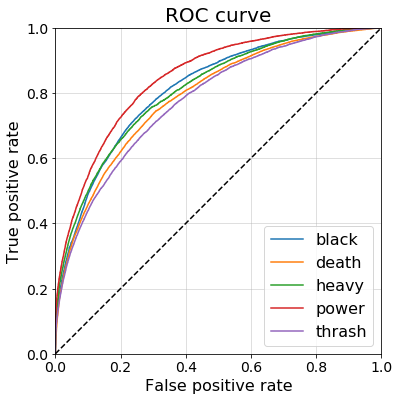

[0.81281877 0.79095052 0.80984639 0.84750585 0.77868239]
AUC ROC score = 0.81 +/- 0.02


In [6]:
rf_params = dict(
    n_estimators=1000,
    max_depth=50,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    n_jobs=-1,
    random_state=0
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('randomforest', RandomForestClassifier(**rf_params))
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# Gradient boosting model

Training on label 'black'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.75 +/- 0.00
Precision:   0.59 +/- 0.00
Recall:      0.63 +/- 0.01
F1-score:    0.61 +/- 0.00
Average confusion matrix:
[[0.67538058 0.09834738]
 [0.08458546 0.14168658]]
Training on label 'death'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.71 +/- 0.00
Precision:   0.61 +/- 0.00
Recall:      0.61 +/- 0.00
F1-score:    0.61 +/- 0.00
Average confusion matrix:
[[0.55586708 0.12555531]
 [0.1254171  0.1931605 ]]
Training on label 'heavy'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.71 +/- 0.00
Precision:   0.52 +/- 0.01
Recall:      0.52 +/- 0.00
F1-score:    0.52 +/- 0.00
Average confusion matrix:
[[0.76069659 0.07686536]
 [0.07830671 0.08413134]]
Training on label 'power'
Fold 1/3
Fold 2/3
Fold 3/3
CV scores:
Accuracy:    0.73 +/- 0.00
Precision:   0.56 +/- 0.01
Recall:      0.54 +/- 0.00
F1-score:    0.55 +/- 0.01
Average confusion matrix:
[[0.75518787 0.07382471]
 [0.07820799 0.09277943]]
Trai

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  0.94


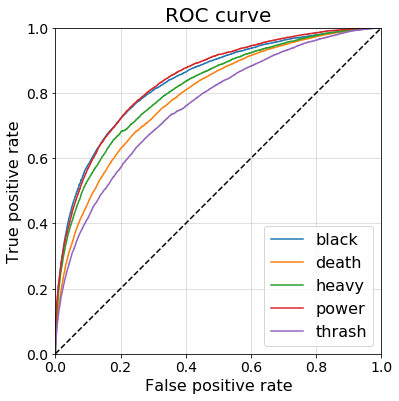

[0.83829282 0.79189654 0.81568165 0.84240111 0.76081149]
AUC ROC score = 0.81 +/- 0.03


In [9]:
lgb_params = dict(
    n_estimators=1000,
    max_depth=30,
    n_jobs=-1,
    random_state=0
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer(dtype=np.float64)),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('lgb', lgb.LGBMClassifier(**lgb_params))
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# Neural network

In [10]:
def create_keras_model(input_dim):
    model = Sequential()
    model.add(layers.Dense(64, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

def keras_batch_generator(X_data, y_data, batch_size):
    number_of_batches = X_data.shape[0] // batch_size
    counter = 0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X_data[index_batch, :].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch), y_batch
        if (counter > number_of_batches):
            counter = 0

In [42]:
keras_params = dict(
    input_dim=10_000,
    epochs=15,
    batch_size=2048,
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('selectkbest', SelectKBest(k=keras_params['input_dim'])),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('neuralnet', KerasClassifier(create_keras_model, **keras_params))
    ]
)
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
y_prob, y_valid = np.zeros((2, y.shape[0]))
scores = np.zeros((n_splits, 4))
confusion_matrices = np.zeros((n_splits, 2, 2))
for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y[:, 0])):
    print("Fold {}/{}".format(i + 1, n_splits))
    X_fold_train, y_fold_train = X[train_idx], y[train_idx, 0]
    X_fold_valid, y_fold_valid = X[valid_idx], y[valid_idx, 0]
    clf = deepcopy(pipeline)
    clf.fit(X_fold_train, y_fold_train)
    try:
        y_fold_prob = clf.predict_proba(X_fold_valid)[:, 1]
    except AttributeError:
        y_fold_prob = clf.predict(X_fold_valid).reshape(-1)
    y_prob[valid_idx] = y_fold_prob
    y_valid[valid_idx] = y_fold_valid
    y_fold_pred = y_fold_prob.round()
    scores[i, 0] = balanced_accuracy_score(y_fold_valid, y_fold_pred)
    scores[i, 1] = precision_score(y_fold_valid, y_fold_pred)
    scores[i, 2] = recall_score(y_fold_valid, y_fold_pred)
    scores[i, 3] = f1_score(y_fold_valid, y_fold_pred)
    confusion_matrices[i] = confusion_matrix(y_fold_valid, y_fold_pred)
avg_accuracy, avg_precision, avg_recall, avg_f1 = scores.mean(axis=0)
std_accuracy, std_precision, std_recall, std_f1 = scores.std(axis=0)
print("CV scores:")
print("Accuracy:    {:.2f} +/- {:.2f}".format(avg_accuracy, std_accuracy))
print("Precision:   {:.2f} +/- {:.2f}".format(avg_precision, std_precision))
print("Recall:      {:.2f} +/- {:.2f}".format(avg_recall, std_recall))
print("F1-score:    {:.2f} +/- {:.2f}".format(avg_f1, std_f1))
print("Average confusion matrix:")
print(confusion_matrices.mean(axis=0) / confusion_matrices.sum() * n_splits)
print("ROC AUC score:")
roc_auc_score(y_valid, y_prob)

Fold 1/3
Epoch 1/15
52248/52248 [==============================] - 5s 90us/step - loss: 0.5539 - binary_accuracy: 0.7324
Epoch 2/15
52248/52248 [==============================] - 5s 89us/step - loss: 0.4501 - binary_accuracy: 0.7908
Epoch 3/15
52248/52248 [==============================] - 5s 88us/step - loss: 0.4075 - binary_accuracy: 0.8131
Epoch 4/15
52248/52248 [==============================] - 5s 90us/step - loss: 0.3759 - binary_accuracy: 0.8314
Epoch 5/15
52248/52248 [==============================] - 5s 89us/step - loss: 0.3506 - binary_accuracy: 0.8464
Epoch 6/15
52248/52248 [==============================] - 5s 88us/step - loss: 0.3283 - binary_accuracy: 0.8564
Epoch 7/15
52248/52248 [==============================] - 5s 89us/step - loss: 0.3087 - binary_accuracy: 0.8679
Epoch 8/15
52248/52248 [==============================] - 5s 89us/step - loss: 0.2900 - binary_accuracy: 0.8772
Epoch 9/15
52248/52248 [==============================] - 5s 88us/step - loss: 0.2719 - binary_

0.8147570264402336

Training on label 'black'
Fold 1/3
Epoch 1/1
52248/52248 [==============================] - 48s 913us/step - loss: 0.4155 - binary_accuracy: 0.8180
Fold 2/3
Epoch 1/1
52250/52250 [==============================] - 48s 911us/step - loss: 0.4128 - binary_accuracy: 0.8166
Fold 3/3
Epoch 1/1
52250/52250 [==============================] - 48s 915us/step - loss: 0.4224 - binary_accuracy: 0.8152
CV scores:
Accuracy:    0.76 +/- 0.00
Precision:   0.60 +/- 0.02
Recall:      0.63 +/- 0.01
F1-score:    0.62 +/- 0.01
Average confusion matrix:
[[0.67893459 0.09479337]
 [0.08261101 0.14366103]]
Training on label 'death'
Fold 1/3
Epoch 1/1
46016/46016 [==============================] - 42s 923us/step - loss: 0.5106 - binary_accuracy: 0.7505
Fold 2/3
Epoch 1/1
46016/46016 [==============================] - 42s 912us/step - loss: 0.5079 - binary_accuracy: 0.7520
Fold 3/3
Epoch 1/1
46016/46016 [==============================] - 42s 904us/step - loss: 0.5081 - binary_accuracy: 0.7527
CV scores:
Accuracy:

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  1.01


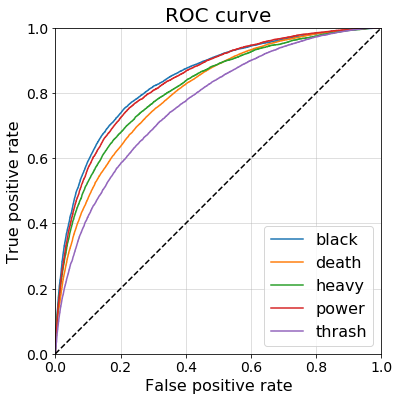

[0.84445619 0.80370395 0.81588365 0.83852935 0.76888179]
AUC ROC score = 0.81 +/- 0.03


In [45]:
keras_params = dict(
    input_dim=100_000,
    epochs=1,
    batch_size=512,
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('selectkbest', SelectKBest(k=keras_params['input_dim'])),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('neuralnet', KerasClassifier(create_keras_model, **keras_params))
    ]
)

br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# Stacked model

In [12]:
class StackedModel(BaseEstimator, TransformerMixin):
    def __init__(self, clfs=[], meta_clf=None):
        self.clfs = clfs
        self.meta_clf = meta_clf

    def fit(self, X, y, split_test_size=0.2):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size)
        y_prob = np.zeros((X_test.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            clf.fit(X_train, y_train)
            y_prob[:, j] = clf.predict_proba(X_test)[:, 1]
        self.meta_clf.fit(y_prob, y_test)
        return self

    def predict(self, X):
        return self.meta_clf.predict(self._predict_base(X))

    def predict_proba(self, X):
        return self.meta_clf.predict_proba(self._predict_base(X))

    def _predict_base(self, X):
        y_prob = np.zeros((X.shape[0], len(self.clfs)))
        for j, clf in enumerate(self.clfs):
            y_prob[:, j] = clf.predict_proba(X)[:, 1]
        return y_prob

training on feature 'black'
fold 1/3
fold 2/3
fold 3/3
CV score: 72.46% +/- 1.07%
Average confusion matrix:
[[0.61624578 0.15748218]
 [0.07856339 0.14770865]]
training on feature 'death'
fold 1/3
fold 2/3
fold 3/3
CV score: 69.46% +/- 0.44%
Average confusion matrix:
[[0.5410587  0.14036369]
 [0.12897111 0.18960649]]
training on feature 'heavy'
fold 1/3
fold 2/3
fold 3/3
CV score: 69.86% +/- 0.15%
Average confusion matrix:
[[0.71439572 0.12316623]
 [0.0740419  0.08839615]]
training on feature 'power'
fold 1/3
fold 2/3
fold 3/3
CV score: 71.62% +/- 0.40%
Average confusion matrix:
[[0.71421802 0.11479456]
 [0.07339033 0.09759709]]
training on feature 'thrash'
fold 1/3
fold 2/3
fold 3/3
CV score: 66.57% +/- 0.69%
Average confusion matrix:
[[0.6830217  0.12411397]
 [0.09929512 0.09356921]]
Multi-label classification report
Accuracy:   0.40
Precision:  0.50
Recall:     0.60
F1-score:   0.54


D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


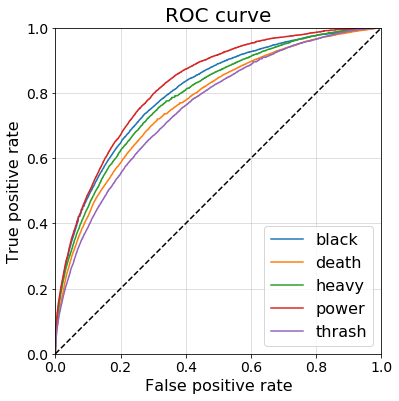

[0.8053241937314842,
 0.7701724475296019,
 0.7912542271348459,
 0.8260229136688134,
 0.7552315871119535]

In [22]:
lgb_params = dict(
    n_estimators=1000,
    max_depth=30,
    n_jobs=-1,
    random_state=0
)
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
stacked_model = StackedModel(
    [
        MultinomialNB(),
        BernoulliNB(),
        lgb.LGBMClassifier(**lgb_params),
    ],
    LogisticRegression(**lr_params)
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer(dtype=np.float(64))),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('stackedmodel', stacked_model)
    ]
)
br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

## Stacking with NN

Training on label 'black'
Fold 1/3
Epoch 1/1
41798/41798 [==============================] - 37s 882us/step - loss: 0.4383 - binary_accuracy: 0.8053
Fold 2/3
Epoch 1/1
41800/41800 [==============================] - 37s 883us/step - loss: 0.4442 - binary_accuracy: 0.8051
Fold 3/3
Epoch 1/1
41800/41800 [==============================] - 37s 886us/step - loss: 0.4494 - binary_accuracy: 0.7972
CV scores:
Accuracy:    0.75 +/- 0.01
Precision:   0.62 +/- 0.01
Recall:      0.61 +/- 0.01
F1-score:    0.61 +/- 0.01
Average confusion matrix:
[[0.68888582 0.08484214]
 [0.08879104 0.137481  ]]
Training on label 'death'
Fold 1/3
Epoch 1/1
36812/36812 [==============================] - 34s 917us/step - loss: 0.5263 - binary_accuracy: 0.7406
Fold 2/3
Epoch 1/1
36812/36812 [==============================] - 34s 924us/step - loss: 0.5271 - binary_accuracy: 0.7368
Fold 3/3
Epoch 1/1
36812/36812 [==============================] - 35s 938us/step - loss: 0.5262 - binary_accuracy: 0.7430
CV scores:
Accuracy:

D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda3\envs\metallyrics\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Hamming loss:  0.91


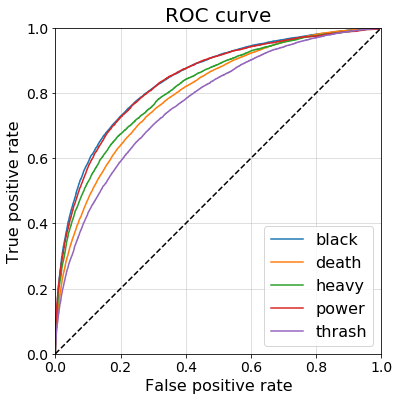

[0.84364726 0.80025013 0.81588745 0.8396794  0.77325707]
AUC ROC score = 0.81 +/- 0.03


In [47]:
lgb_params = dict(
    n_estimators=1000,
    max_depth=30,
    n_jobs=-1,
    random_state=0
)
lr_params = dict(
    solver='lbfgs',
    max_iter=1000,
    random_state=0
)
keras_params = dict(
    input_dim=100_000,
    epochs=1,
    batch_size=512,
)
stacked_model = StackedModel(
    [
        MultinomialNB(),
        BernoulliNB(),
        lgb.LGBMClassifier(**lgb_params),
        KerasClassifier(create_keras_model, **keras_params)
    ],
    LogisticRegression(**lr_params)
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer(dtype=np.float64)),
        ('selectkbest', SelectKBest(k=keras_params['input_dim'])),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('stackedmodel', stacked_model)
    ]
)
br = BinaryRelevance(pipeline, genres)
mlc = br.cross_validate(X, y, n_splits=3, verbose=True)
mlc.print_report()
fig, auc = mlc.plot_roc_curve()
plt.show()
print(auc)
print("AUC ROC score = {:.2f} +/- {:.2f}".format(auc.mean(), auc.std()))

# Test on new lyrics

In [12]:
# pipeline = Pipeline(
#     [
#         ('vectorizer', CountVectorizer()),
#         ('oversampler', RandomOverSampler(random_state=0)),
#         ('multinomialnb', MultinomialNB())
#     ]
# )
lgb_params = dict(
    n_estimators=1000,
    max_depth=30,
    n_jobs=-1,
    random_state=0,
)
pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer(dtype=np.float64)),
        ('oversampler', RandomOverSampler(random_state=0)),
        ('lgb', lgb.LGBMClassifier(**lgb_params))
    ]
)
br = BinaryRelevance(pipeline, genres)
br.fit(X, y)

training binary classifier for label: black
training binary classifier for label: death
training binary classifier for label: heavy
training binary classifier for label: power
training binary classifier for label: thrash


In [13]:
# Deathspell Omega
test = """
Our skies are forever black
Here is no signs of life at all
For burning spirits we are
Consuming your small universe
Slowly but surely
No one believes in us
We came from realms of Hell
No eyes can see us
We're not made of flesh and blood
In times past we reigned everywhere
One day life emerged from the chaos
We still dominate but this error must end
The void shall swallow the decease
Slowly but surely
Changing from a dimention to another..
of being possession
Out of the nihilistic kingdom
to spread destruction
An unseen invasion to conquer
the spiled land...till total extinxion
The human claim to rule their world
They don't even understand the meaning
of death
A black hole is eating each soul
The ultimate desolation will supress
life and prevail again
Then there won't be mistakes anymore
The apotheosis of Satan approaches
He who is inside of us
"""
X_test = np.array([' '.join(test.lower().split())])
y_prob = br.predict_proba(X_test)[0]
genre_probs = [(genre, y_prob[i]) for i, genre in enumerate(genres)]
genre_probs.sort(key=lambda x: 1 - x[1])
print("Classification:")
if genre_probs[0][1] < 0.5:
    print("NONE")
else:
    print(", ".join([genre.upper() for (genre, prob) in genre_probs if prob >= 0.5]))
print("\nIndividual genre probabiliites:")
for genre, prob in genre_probs:
    print("{:<10s}{:>3.0f}%".format(genre, 100 * prob))

Classification:
DEATH, THRASH

Individual genre probabiliites:
death      59%
thrash     55%
black      42%
power      38%
heavy      21%


In [14]:
# Lamb of God
test = """
If there was a single day I could live... a single breath I could take
I'd trade all the others away.
The blood's on the wall, so you'd might as well just admit it
And bleach out the stains, commit to forgetting it.
You're better off empty and blank, than left with a single pathetic trace of this
Smother another failure, lay this to rest.
Console yourself, you're better alone
Destroy yourself, see who gives a fuck
Absorb yourself, you're better alone
Destroy yourself.
I'll chain you to the truth, for the truth shall set you free
I'll turn the screws of vengeance and bury you with honesty
I'll make all your dreams come to life, then slay them as quickly as they came
Smother another failure, lay this to rest.
Console yourself, you're better alone
Destroy yourself, see who gives a fuck
Absorb yourself, you're better alone
Destroy yourself, see who gives a fuck.
Failure.
If there was a day I could live, if there was a single breath I could take
I'd trade all the others away.
"""
X_test = np.array([' '.join(test.lower().split())])
y_prob = br.predict_proba(X_test)[0]
genre_probs = [(genre, y_prob[i]) for i, genre in enumerate(genres)]
genre_probs.sort(key=lambda x: 1 - x[1])
print("Classification:")
if genre_probs[0][1] < 0.5:
    print("NONE")
else:
    print(", ".join([genre.upper() for (genre, prob) in genre_probs if prob >= 0.5]))
print("\nIndividual genre probabiliites:")
for genre, prob in genre_probs:
    print("{:<10s}{:>3.0f}%".format(genre, 100 * prob))

Classification:
DEATH, THRASH

Individual genre probabiliites:
death      71%
thrash     68%
power       3%
heavy       3%
black       2%


In [15]:
# Nokturnal Mortum
test = """
The edge of continuity for dream and reality.
Shaman is dancing his dance of death;
the masks of the demonssurrounding me.
This is my wedding ritual that gives the violence.
The fog of the night, the dark water...
to run through the expanse of light.
The mysteries of civilizations
that left the Earth more of ten times return to me;
it gives no repose to me again and again.
Standing in the forestand seeing the atricities...
all is inside me, and it comes back in the dreams.
The shaman dances, the masks are waiting for its demon.
The knife is in my hand.
The fog... will never crawl away.
My words are devoured by the bestial of silence
and in invisible chains shackle my moves.
The dream continues it's gush to reality
and the shaman drums louder the rhytm to his dance of death.
"""
X_test = np.array([' '.join(test.lower().split())])
y_prob = br.predict_proba(X_test)[0]
genre_probs = [(genre, y_prob[i]) for i, genre in enumerate(genres)]
genre_probs.sort(key=lambda x: 1 - x[1])
print("Classification:")
if genre_probs[0][1] < 0.5:
    print("NONE")
else:
    print(", ".join([genre.upper() for (genre, prob) in genre_probs if prob >= 0.5]))
print("\nIndividual genre probabiliites:")
for genre, prob in genre_probs:
    print("{:<10s}{:>3.0f}%".format(genre, 100 * prob))

Classification:
BLACK

Individual genre probabiliites:
black      77%
death      19%
power       4%
heavy       3%
thrash      3%


In [16]:
# Waking the Cadaver
test = """
Full force assault,
With my arsenal,
Of destruction,

Seeing the neighborhood,
With a horrid stare,
Blasting authority,

You will never catch me,
On my killing spree,
Appetite for death,
Realize there is no God.

You will never catch me,
On my killing spree,
Appetite for death,
Realize there is no God.

Full force assault,
With my arsenal,
Of destruction,

Seeing the neighborhood,
With a horrid stare,
Blasting authority,

You will never catch me,
On my killing spree,
Appetite for death,
Realize there is no God.
"""
X_test = np.array([' '.join(test.lower().split())])
y_prob = br.predict_proba(X_test)[0]
genre_probs = [(genre, y_prob[i]) for i, genre in enumerate(genres)]
genre_probs.sort(key=lambda x: 1 - x[1])
print("Classification:")
if genre_probs[0][1] < 0.5:
    print("NONE")
else:
    print(", ".join([genre.upper() for (genre, prob) in genre_probs if prob >= 0.5]))
print("\nIndividual genre probabiliites:")
for genre, prob in genre_probs:
    print("{:<10s}{:>3.0f}%".format(genre, 100 * prob))

Classification:
DEATH, HEAVY

Individual genre probabiliites:
death      75%
heavy      50%
thrash     49%
black      27%
power      10%


In [17]:
# Wolves in the Throne Room
test = """
The journey is long and steep
Sweat turns lack and runs with dust
Here I seek the edge of the world
The secrets that lie behind the veil
The rapture of the universe

As the sun pours down like honey
Three sentries loom at the skyline
Bravely staring on
Our sun of eternity pours down as it shines bright

Many souls slumber
On the mountainside below
Dressed in royal robes of green and red

My left hand points to the earth
My right towards the starry sky
Writhing serpent belt of eternity
Wrapped round my waist
Black banner blows in the wind
Emblazoned with the white rose of death

Under the cover of night, by fire light
Blood smoke in my lungs
Moss and blood in my hair
Ash in my eyes, I grip the torch
My light illuminates her ritual
Lost sigil burns in the dark
Her ecstasy shakes the cannon
The future now glows with a blue brilliance
In my mind's eye I can see a stronghold
With a moat of pure spring water
Spires of cedar and fir
"""
X_test = np.array([' '.join(test.lower().split())])
y_prob = br.predict_proba(X_test)[0]
genre_probs = [(genre, y_prob[i]) for i, genre in enumerate(genres)]
genre_probs.sort(key=lambda x: 1 - x[1])
print("Classification:")
if genre_probs[0][1] < 0.5:
    print("NONE")
else:
    print(", ".join([genre.upper() for (genre, prob) in genre_probs if prob >= 0.5]))
print("\nIndividual genre probabiliites:")
for genre, prob in genre_probs:
    print("{:<10s}{:>3.0f}%".format(genre, 100 * prob))

Classification:
BLACK

Individual genre probabiliites:
black      63%
death      45%
thrash     16%
power       2%
heavy       0%


In [18]:
# Ne Obliviscaris
test = """
ALL HORIZONS FALL THROUGH DYING STAINS
A CRIMSON CROWN TO CALL MY OWN
O HOME IS EVERYWHERE I VOYAGE
AND DARKNESS IS ALWAYS WITH ME...

I CALL TO THE SIRENS ECHOING IN SWEET LAUGHTER
BROKEN HOPES 'NEATH THE SURFACE
WITH HAUNTING EYES THEY STARE...
through black waters, wearing tresses
a figurehead warped, stares homesick afar

NEVER DEPTHS... MY DEAR DESPAIR
NEVER

BLIND IN DELIRIUM, NAVIGATING THE CONTINUUM FLUX... NOTHING
SUBMERGED IN LIMBO, OF NAUTICA THEY SING... TRUE MAJESTY
OCEANS WIDE, EYES WIDE... FOREVER TO TREASURE... CARRY ON
INFUSING INSIGHT, THE FABRIC OF SPACE IGNITED

silent time reveals tragedies chartered
all triumphs were drowned...and the sirens too...
SILENT TIME REVEALS...
ALL TRIUMPHS WERE DROWNED...
symphony for the pilgrim, intrinsic wake, opulent discordant soul... my arabesque
setting sail from paradox lost to a paradise found
PARADISE, PARADISE FOUND
PARADISE, PARADISE FOUND
"""
X_test = np.array([' '.join(test.lower().split())])
y_prob = br.predict_proba(X_test)[0]
genre_probs = [(genre, y_prob[i]) for i, genre in enumerate(genres)]
genre_probs.sort(key=lambda x: 1 - x[1])
print("Classification:")
if genre_probs[0][1] < 0.5:
    print("NONE")
else:
    print(", ".join([genre.upper() for (genre, prob) in genre_probs if prob >= 0.5]))
print("\nIndividual genre probabiliites:")
for genre, prob in genre_probs:
    print("{:<10s}{:>3.0f}%".format(genre, 100 * prob))

Classification:
NONE

Individual genre probabiliites:
power      39%
death      19%
black       5%
thrash      5%
heavy       4%


In [19]:
# Car Bomb
test = """
Dark smiles saying nothing
The warpath, straight and lonely
Both sides feel the cold front closing in

Reveal the frozen pieces of earth

Can’t hear the hidden sounds from its closed mouth
No more secret truths said into the soundproof walls

They sing we’re restored to life

From the dust of this planet you sing
Stand up and sing
Ashes in ears
There’s no way home
Just sing this song

They sing we’re restored to life
Pull the rusting nails from these walls
Peel off your broken nails

Wake wake up the sun
Just take it all back
"""
X_test = np.array([' '.join(test.lower().split())])
y_prob = br.predict_proba(X_test)[0]
genre_probs = [(genre, y_prob[i]) for i, genre in enumerate(genres)]
genre_probs.sort(key=lambda x: 1 - x[1])
print("Classification:")
if genre_probs[0][1] < 0.5:
    print("NONE")
else:
    print(", ".join([genre.upper() for (genre, prob) in genre_probs if prob >= 0.5]))
print("\nIndividual genre probabiliites:")
for genre, prob in genre_probs:
    print("{:<10s}{:>3.0f}%".format(genre, 100 * prob))

Classification:
HEAVY

Individual genre probabiliites:
heavy      71%
thrash     30%
black      13%
death      13%
power      11%


In [20]:
# Death Angel
test = """
Metal mayhem; hit the stage
Thrashing to the madness,
You can feel the rage!

Denim, leather, in the crowd
Feel your ears are bleeding,
Wanna hear it loud!

Thrasher! [4x]

Posers strike us in the back
I can’t take their bullshit,
Turn around and attack
(Attack!)

Metal bodies slamming into me,
How I live my life
And baby can’t you see?

Thrashers! [4x]

Smashing, thrashing, on your knees
You beg for mercy
Smashing, thrashing, on your knees
You plead for mercy

Thrasher! [4x]

Fighting, fall off the stage
Screaming with a rage
Thrashing, lose control
Smashing I like drugs
Madness, all around
Falling to the ground
Dying for your breath
Living to your death

Thrashing, smashing, on their knees
You beg for mercy
Thrashing, smashing, on their knees
You plead for mercy

Thrasher! [4x]
"""
X_test = np.array([' '.join(test.lower().split())])
y_prob = br.predict_proba(X_test)[0]
genre_probs = [(genre, y_prob[i]) for i, genre in enumerate(genres)]
genre_probs.sort(key=lambda x: 1 - x[1])
print("Classification:")
if genre_probs[0][1] < 0.5:
    print("NONE")
else:
    print(", ".join([genre.upper() for (genre, prob) in genre_probs if prob >= 0.5]))
print("\nIndividual genre probabiliites:")
for genre, prob in genre_probs:
    print("{:<10s}{:>3.0f}%".format(genre, 100 * prob))

Classification:
THRASH, HEAVY

Individual genre probabiliites:
thrash     93%
heavy      69%
black      42%
death      24%
power      13%
